<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of image data with augmentation and classification

Das Ziel dieses Beispieles ist es die Organisation, den Import und die Vorbereitung von Bilddaten für eine Klassifikation zu erklären. Dabei werden folgende Schritte durchgeführt:

- Dynamisches Laden und entpacken der Bilddaten von einer externen Quelle
- Review der Organisation auf dem Filesystem
- Laden der Daten
- Transformationen
- Augmentierung
- Training
- Analyse
- Verbesserung

Der verwendete Datensatz heisst caltech101[3] mit 101 Klassen und jeweils 40 bis 800 Bildern pro Klasse. Die Bilder haben 200 - 300 Pixel Auflösung in Farbe.

Quellen für die Beispiele und Daten:

- [1] [https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [2] [https://github.com/bhavul/Caltech-101-Object-Classification](https://github.com/bhavul/Caltech-101-Object-Classification)
- [3] [http://www.vision.caltech.edu/Image_Datasets/Caltech101/](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)


In [3]:
#
# Import der Module
#
import numpy as np
from urllib.request import urlretrieve
import os
import tarfile
import operator
import random
from PIL import Image
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


In [4]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


2.0.0


# Hilfsfunktionen 

In [27]:
urlDataSource = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
localExtractionFolder = 'data/caltech101'
localDataArchive = 'data/caltech101/caltech101.tar.gz'

In [28]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,dataset_file_path):
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden der Daten

In [29]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localDataArchive)

archive already downloaded.


In [30]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/caltech101/caltech101.tar.gz to data/caltech101 done.


# Organisation von Bilddaten auf dem Filesystem

Eine gute Einführung in das Thema ist zu finden unter

- [Brownlee](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/) 
- [Sarkar](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)

# Erzeugen der Trainingsdaten

In [31]:
#
# Hilfsfunktionen
#

def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("data directory not found.")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def return_images_per_category(data_directory):
    folder = os.path.join(data_directory,"101_ObjectCategories")
    #print(folder)
    categories=[d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))]
    #print(categories)
    return categories

#
# Lesen der Bilddaten aus einer Datei. Anpassen der Größe auf 300x200 (Breite x Höhe) Pixel.
#
def read_image(image_path):
    #img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)    
    im = Image.open(image_path).convert("RGB").resize((300,200))
    np_img = np.array(im)
    return np_img




def create_training_data(data_directory,fraction):
    
    i = 0
    X = []
    Y = []
    
    print("started to read dataset from {}.".format(data_directory) )
    
    for category in return_images_per_category(data_directory):
        
        if category == 'BACKGROUND_Google':
            continue
        
        print(".",end='')
        
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                continue
                
            if random.uniform(0, 1) > fraction:
                continue
                
            X.insert(i, read_image(image) )
            Y.insert(i, category )
            i += 1
    print("finished reading dataset.")
    X = np.array(X)
    return X,Y


In [32]:
#
# Erzeugen der Trainingsdaten
#
X, Y = create_training_data(localExtractionFolder,0.4)

print('data X={}, y={}'.format(X.shape, len(Y)) )

started to read dataset from data/caltech101.
.....................................................................................................finished reading dataset.
data X=(2513, 200, 300, 3), y=2513


In [33]:
#
# Transformation der Labels in one-hot encoding
#
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_one_hot = to_categorical(Y_integer_encoded)


In [34]:
#
# Normalisieren der Bilddaten
#
X_normalized = ( X.astype(np.float64) / 255 ) + 0.001


#
# Löschen von X um Speicher gezielt freizumachen
#
del X

In [35]:
#
# Split der Daten in Train und Test(validation) Datensätze
#
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)
del X_normalized


#
# gültige Werte in X_train, X_validation, Y_train, Y_validation, label_encoder, data_directory
#

# Prüfen der Daten

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train: X=(1884, 200, 300, 3), y=(1884, 101)
test: X=(629, 200, 300, 3), y=(629, 101)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


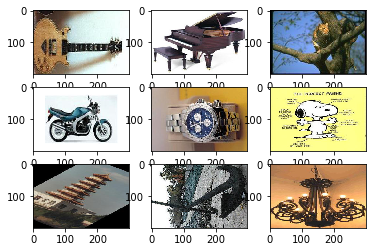

In [36]:
#
# Form der Daten
#
print('train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('test: X=%s, y=%s' % (X_validation.shape, Y_validation.shape))

#
# Plot von Bildern
#
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])
pyplot.show()

In [37]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(101, activation='softmax'))
    return model

In [38]:
#
# Compile und Training des Modelles
#

model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

callbacks = [ModelCheckpoint('model_cnn_weights.h5', monitor='val_acc', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]

history = model_cnn.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Train on 1884 samples, validate on 629 samples
Epoch 1/1
1884/1884 [==============================] - 325s 173ms/step - loss: 4.7508 - accuracy: 0.0934 - val_loss: 4.1788 - val_accuracy: 0.2035


/Users/dietmar/opt/anaconda3/envs/wificlass/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [39]:
#
# Evaluierung des Modelles
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.203 


In [42]:
#
# Ausgabe des Trainingsverlaufes
#
def summarize_diagnostics(history,modelname):
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='green', label='test')
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='green', label='test')
    pyplot.subplots_adjust(hspace=0.5)
    pyplot.savefig( 'results/' + modelname + '_plot.png')
    pyplot.show()
    pyplot.close()

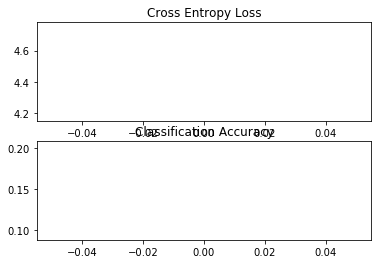

In [44]:
summarize_diagnostics(history,'model_cnn')

# Optimiertes Laden der Bilder

Die bisherige Ladefunktion hat alle Bilder in den Speicher geladen. Das führt schnell dazu, dass der Hauptspeicher ausgeht. Daher benötigen wir eine Funktion, die Bilder der Reihe nach in den Speicher lädt und für das Training zur Verfügung stellt.

Eine solche Funktion kann mit einem python **Generator** implementiert werden. Die Erklärung von Generatoren ist hier zu finden [2]. Das Tutorial zum Laden mit Generatoren ist hier [1] zu finden.

Quellen:
- [1][https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)
- [2] [https://www.python-kurs.eu/generatoren.php](https://www.python-kurs.eu/generatoren.php)

In [47]:
#
# Anlegen eines Generators für Bilder
#
datagen = ImageDataGenerator()
# prepare iterator
it_train = datagen.flow(X_train, Y_train, batch_size=64)

In [49]:
#
# Training
#

model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

#
# Neue Funktion fit_generator
#
steps = int(X_train.shape[0] / 64)
history = model_cnn.fit_generator(it_train, steps_per_epoch=steps, epochs=10, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/2
29/29 [==============================] - 317s 11s/step - loss: 3.8149 - accuracy: 0.2038 - val_loss: 3.6173 - val_accuracy: 0.2750
Epoch 2/2
29/29 [==============================] - 305s 11s/step - loss: 2.7456 - accuracy: 0.3868 - val_loss: 3.0611 - val_accuracy: 0.4229


accuracy 0.423 


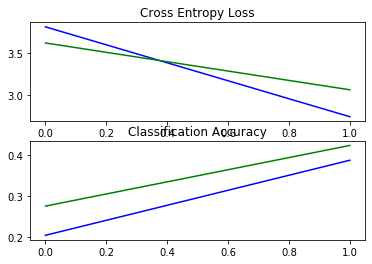

In [50]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )
summarize_diagnostics(history,'model_cnn_gen')

# Optimierung durch Augmentierung

Augmentierung erweitert den Trainingsdatensatz um künstlich erzeugte Bilder. Damit wird erreicht, dass ein Modell robuster wird und sich nicht auf einzelne Pixel bezieht. Methoden der Augmentierung für Bilder sind:

- Breite und Höhe des Bildinhaltes ändern (width_shift_range, height_shift_range)
- Spiegelung (flip)
- Rotation (rotation_range)
- Zoomen (zoom_range)
- Helligkeit (brightness_range)
- Verzerrung (shear_range)

Das Zufügen von Rauschen kann in Keras nicht direkt über den [ImageDataGenerator](https://keras.io/preprocessing/image/) eingestellt werden. Dies wird aber durch die Verwendung von Dropout annähernd simuliert.


In [51]:
#
# Anlegen eines Generators für Bilder
#
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=10, zoom_range=0.1)
# prepare iterator
it_train = datagen.flow(X_train, Y_train, batch_size=64)

In [53]:
#
# Training
#
steps = int(X_train.shape[0] / 64)

model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

history = model_cnn.fit_generator(it_train, steps_per_epoch=steps, epochs=50, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/2
29/29 [==============================] - 322s 11s/step - loss: 2.9450 - accuracy: 0.3582 - val_loss: 2.7975 - val_accuracy: 0.4340
Epoch 2/2
29/29 [==============================] - 317s 11s/step - loss: 2.5665 - accuracy: 0.4198 - val_loss: 2.7120 - val_accuracy: 0.4579


accuracy 0.458 


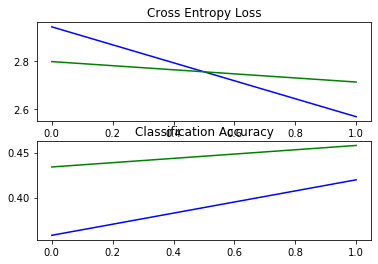

In [54]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )
summarize_diagnostics(history,'model_cnn_aug')